In [1]:
# Xiaopu Peng

In [1]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [2]:
# check whats in the root folder
from subprocess import check_output
print(check_output(['ls', './']).decode('utf8'))

ExpCompareAll.ipynb
ExpCompareBasic.ipynb
ExpFixWorkload.ipynb
ExpUPScompare.ipynb
UPScompare.eps
__pycache__
compareAll.eps
comparision
fixWorkloadCompare.eps
fixWrokloadCompare.eps



# Imports

In [3]:
import sys
sys.path.insert(0, '/Users/xiaopupeng/Dropbox/WorkSpace/Redux/')
import random
import Methods as mt
import numpy as np
import pandas as pd
# %matplotlib inline
%matplotlib notebook
# %matplotlib widget
import matplotlib.pyplot as plt
# import Redux as rd
plt.style.use('ggplot')
# plt.style.use('default')

## Initialize

In [4]:
# ############CONSTANT############
# ratio of stats count when start the arithmetic average estimate
scaleRatio = 0.01
# ability of ups devise, could be more sophisticated in future (kWh)
upsCapability = 500
# the workload processing capability of data center (by kWh energy need)
workloadCapability = 2500
# ups and renewable energy price ($)
upsPrice = 0.02
solarPrice = 0.09
windPrice = 0.15

# ##############INITIALIZE###################
# initialized ups original storage by ratio
initUpsStorage = upsCapability * 0.5
# the initialized threshold of grid price ($)
initGridpriceThreshold = 1.0
# initialized high and low ratio of current workload for workload shaving
initCurWorkloadRatio = 0.2
# initialized stable renewable supply level
initStableRenSupply = 500
# initialize statistic recorders  and
gridpriceStat = []
workloadStat = []
renSupplyStat = []
fluRenSupplyStat = []  # renewable supply fluctuation
stableRenSupplyStat = []  # stable renewable supply

renSupplyStat = []
renSupplyAccu = []
gridSupplyStat = []
gridSupplyAccu = []
upsSupplyStat = []
upsSupplyAccu = []

# initialize all statistical records
reduxStat = []
reduxAccu = []

In [5]:
%whos
# dir()
# globals()
# locals()

Variable                 Type        Data/Info
----------------------------------------------
check_output             function    <function check_output at 0x10fe42b00>
fluRenSupplyStat         list        n=0
gridSupplyAccu           list        n=0
gridSupplyStat           list        n=0
gridpriceStat            list        n=0
initCurWorkloadRatio     float       0.2
initGridpriceThreshold   float       1.0
initStableRenSupply      int         500
initUpsStorage           float       250.0
mt                       module      <module 'Methods' from '/<...>kSpace/Redux/Methods.py'>
np                       module      <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
pd                       module      <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
plt                      module      <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
random                   module      <module 'random' from '/U<...>lib/python3.7/random.py'>
reduxAccu                list      

## Dataset

In [6]:
dataDir = '/Users/xiaopupeng/Dropbox/WorkSpace/Redux/data/'
workloadData, gridpriceData, solarSupplyData, windSupplyData, renSupplyData = mt.loadData(dataDir)

In [7]:
workloadData

array([1827.71015778, 2150.70074927, 1293.36615811, ..., 1452.76602733,
        759.70224486, 1377.1005759 ])

<IPython.core.display.Javascript object>


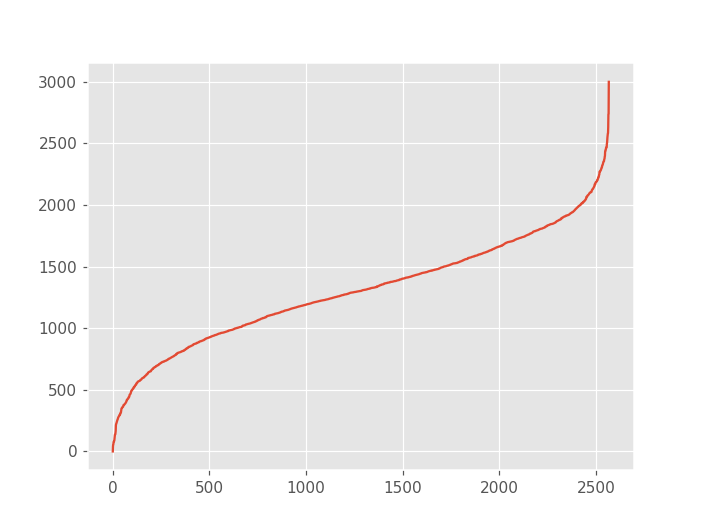

In [8]:
plt.plot(sorted(workloadData))
plt.show()

<IPython.core.display.Javascript object>


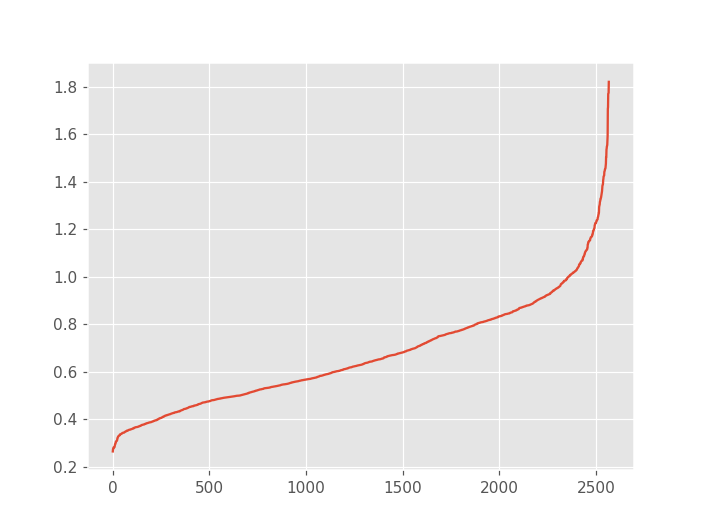

In [9]:
plt.close()
plt.plot(sorted(gridpriceData))
plt.show()

<IPython.core.display.Javascript object>


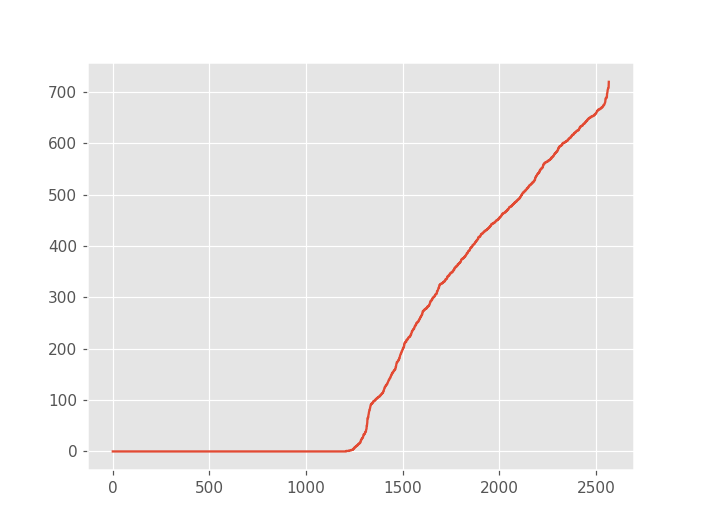

In [10]:
plt.close()
plt.plot(sorted(solarSupplyData))
plt.show()

In [ ]:
plt.close()
plt.plot(sorted(windSupplyData))
plt.show()

<IPython.core.display.Javascript object>


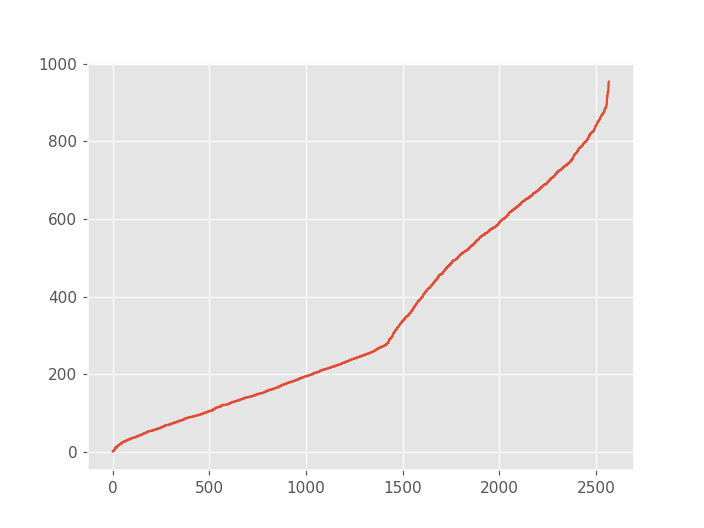

In [12]:
plt.close()
plt.plot(sorted(renSupplyData))
plt.show()

## Preprocess (need solar&wind model)

# topLevel

In [13]:
totalCostAccu = []
totalCostAccuResult = []
renSupplyExpAccu = []
renSupplyExpAccuResult = []
gridSupplyExpAccu = []
gridSupplyExpAccuResult = []
upsSupplyExpAccu = []
upsSupplyExpAccuResult = []

In [14]:
curTime = 0
finTime = 2568  # number of timeslots
WINDOW = finTime * scaleRatio
for fixRenSupply in [50, 350, 650, 950]:
    gridpriceThreshold = 1.0
    workloadPool = 0
    curWorkloadRatio = initCurWorkloadRatio
    stableRenSupply = initStableRenSupply
    upsStorage = initUpsStorage
    fluRenSupplyStat = []  # renewable supply fluctuation
    stableRenSupplyStat = []  # stable renewable supply

    # initialize all statistical records
    reduxStat = []
    reduxAccu = []
    gridpriceStat = []
    workloadStat = []
    renSupplyStat = []
    
    renSupplyStat = []
    renSupplyAccu = []
    gridSupplyStat = []
    gridSupplyAccu = []
    upsSupplyStat = []
    upsSupplyAccu = []
    
    print(fixRenSupply)
    curTime = 0
    while curTime < finTime:
        # print('current time:', curTime)
        # derive renewable price by weighted average from wind and solar price
        renPrice = (windSupplyData[curTime] * windPrice + solarSupplyData[curTime] * solarPrice) / (windSupplyData[curTime] + solarSupplyData[curTime])

        # get the current grid price, append to grid price statistic and decide whether it is high or low

        gridPrice = gridpriceData[curTime]

        gridpriceStat.append(gridPrice)
        # call method to estimate grid price state
        gridpriceThreshold, gridpriceState = mt.estimateGridPriceState(gridpriceStat, gridpriceThreshold, finTime, gridPrice, scaleRatio)

        # get the current workload and append to workload statistic, use real trace data for the next step
        curWorkload = workloadData[curTime]

        # first, do workload shaving to avoid over-capability load
        curWorkload, workloadPool = mt.workloadShaving(curWorkload, workloadCapability, workloadPool)
        workloadStat.append(curWorkload)

        # get the current workload and append to workload statistic
        renSupply = fixRenSupply
        renSupplyStat.append(renSupply)

        # calculate greenswitchCost (noRedux, but with renewable energy)
        #     greenswitchCost = mt.calculateGreenswitchCost(renSupply, curWorkload, workloadPool, gridPrice, renPrice)
        #     greenswitchStat.append(greenswitchCost)
        #     greenswitchAccu.append(sum(greenswitchStat))

        # then smoothing the current workload by exponential windowed avarage
        curWorkload, workloadPool = mt.workloadSmoothing(curWorkload, workloadPool, workloadStat, WINDOW)

        # update the high and low ratio of workload according to smoothed workload, will approach to 0.8 and 0.2 as when more workload recorded
        curWorkloadHighRatio, curWorkloadLowRatio = mt.updateWorkloadRatio(workloadStat, finTime, curWorkloadRatio, scaleRatio)

        workloadState = mt.updateWorkloadState(curWorkload, curWorkloadHighRatio, curWorkloadLowRatio, workloadCapability)

        # decide utilization level of ups for current time spot
        upsAbility = mt.updateUpsUtilityLevel(workloadState, upsCapability)

        ############################################
        # define renewable state
        # we need to figure out how to define fluctuate and tell why we still use grid as
        # much as possible when grid price is low(by always set a low price), otherwise we lost our motivation
#         renState = mt.defineRenState(renSupply, renSupplyStat, renSupplyData, WINDOW)
        if renSupply > 900:
            renState = 'stable'
        if renSupply < 100:
            renState = 'outage'
        else:
            renState = 'fluctuate'
        ##############################################

        # smoothing supply and demand if necessary
        if renState == 'fluctuate':
            # record the fluctuating renewable supply
#             fluRenSupplyStat.append(renSupply)
            # update the stable renewable supply level by historical fluctuate renewable supply stat
#             stableRenSupply = mt.getStableRenSupply(fluRenSupplyStat, WINDOW)
            stableRenSupply = renSupply
            # conduct renewable energy supply
            renSupply, upsStorage, stableGridSupply, upsSupplyFlu = mt.renSupplySmooth(gridpriceState, gridPrice, renSupply, renPrice, stableRenSupply, upsAbility, upsStorage)
        else:
            upsSupplyFlu = 0
            stableGridSupply = 0

        # dynamically decide overpeak workload level
        workloadOVR = mt.updateOverpeak(gridpriceState, curWorkloadHighRatio, curWorkloadLowRatio, workloadCapability, workloadPool, renState, renSupply, stableRenSupply, gridPrice, renPrice)

        # status['workloadState'] == 'overPeak'
        curWorkload, workloadPool = mt.workloadShaving(curWorkload, workloadOVR, workloadPool)

        # decide whether discharge or recharge UPS
        upsSupply, upsStorage = mt.updateUpsSupply(gridpriceState, curWorkload, workloadOVR, renState, upsStorage, upsCapability, upsSupplyFlu)
        
        upsSupplyStat.append(abs(upsSupply))
        upsSupplyAccu.append(sum(upsSupplyStat))

        # waste renSupply if it is higher than curWorkload
        if renSupply + upsSupply > curWorkload:
            renSupply = curWorkload - upsSupply
            
        renSupplyStat.append(renSupply)
        renSupplyAccu.append(sum(renSupplyStat))

        # find gridSupply by supply constrain
        gridSupply = curWorkload - renSupply - upsSupply + stableGridSupply
        
        gridSupplyStat.append(gridSupply)
        gridSupplyAccu.append(sum(gridSupplyStat))
        
        # calculate redux cost
        reduxCost = gridPrice * gridSupply + renPrice * renSupply + upsPrice * abs(upsSupply)
        
        reduxStat.append(reduxCost)
        reduxAccu.append(sum(reduxStat))
        
        curTime += 1
        
    upsSupplyExpAccuResult.append(upsSupplyAccu[-1])
    upsSupplyExpAccu.append(upsSupplyAccu)
    renSupplyExpAccuResult.append(renSupplyAccu[-1])
    renSupplyExpAccu.append(renSupplyAccu)
    gridSupplyExpAccuResult.append(gridSupplyAccu[-1])
    gridSupplyExpAccu.append(gridSupplyAccu)
    totalCostAccuResult.append(reduxAccu[-1])
    totalCostAccu.append(reduxAccu)

print('Finished')

50
350
650
950
Finished


### Result

In [15]:
fixRenAccuResult = totalCostAccuResult
fixRenAccu = totalCostAccu

In [16]:
renSupplyExpAccuResult

[256800, 1920289.844965537, 3465187.4407939725, 5007100.575607464]

In [17]:
upsSupplyExpAccuResult

[84250.0, 21350.0, 21750.0, 21850.0]

In [18]:
gridSupplyExpAccuResult

[3782550.2407517764,
 2892764.2617443674,
 2045042.1910935168,
 1234876.4721442568]

In [19]:
energySupply = [0]*4
for i in range(len(renSupplyExpAccuResult)):
    energySupply[i] = renSupplyExpAccuResult[i] + upsSupplyExpAccuResult[i] + gridSupplyExpAccuResult[i]
energySupply

[4123600.2407517764, 4834404.106709905, 5531979.631887489, 6263827.047751721]

In [20]:
fixRenAccuResult

[2400003.791151747, 2027621.1389474766, 1604662.1180750006, 1177395.498865496]

<IPython.core.display.Javascript object>


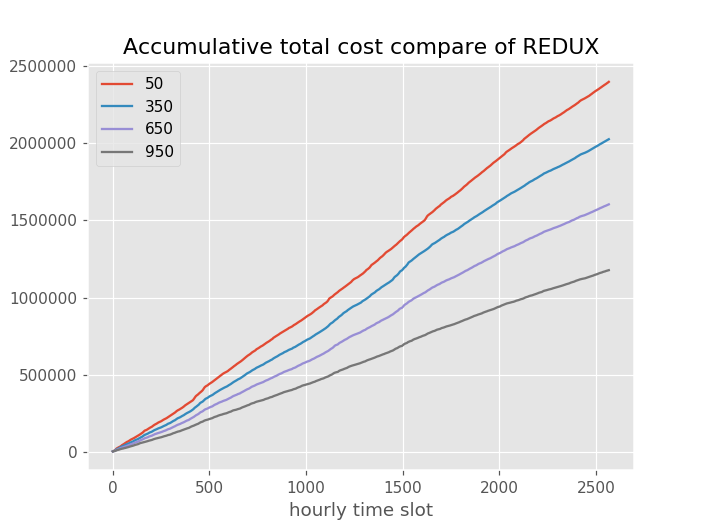

In [21]:
plt.close()
plt.plot(fixRenAccu[0], label='50')
plt.plot(fixRenAccu[1], label='350')
plt.plot(fixRenAccu[2], label='650')
plt.plot(fixRenAccu[3], label='950')
plt.xlabel('hourly time slot')
plt.ylabel('dollars')
plt.title('Accumulative total cost compare of REDUX')
plt.legend(loc='best')
plt.show()

In [13]:
# plt.savefig('compare.eps')
plt.close()

<IPython.core.display.Javascript object>


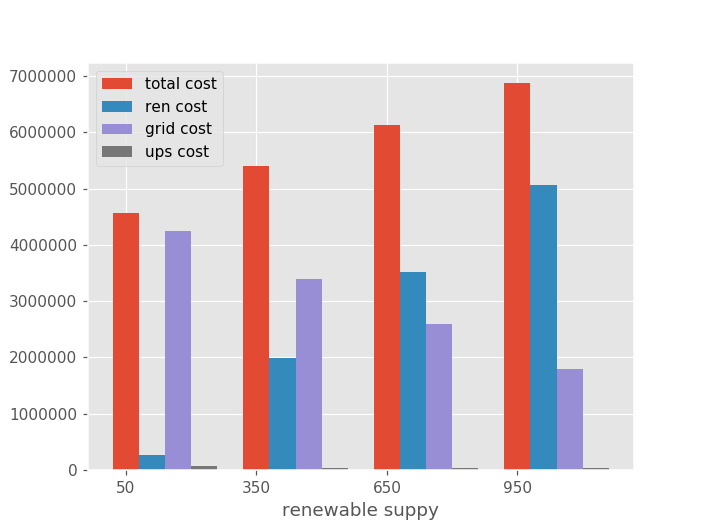

In [14]:
plt.close()
barWidth = 0.2
xlabel = ['50', '350', '650', '950']
index = np.arange(4)
plt.bar(index, energySupply, barWidth, label='total cost')
plt.bar(index + barWidth, renSupplyExpAccuResult, barWidth, label='ren cost')
plt.bar(index + barWidth*2, gridSupplyExpAccuResult, barWidth, label='grid cost')
plt.bar(index + barWidth*3, upsSupplyExpAccuResult, barWidth, label='ups cost')
# plt.plot(energySupply, label = 'energySupply')
# plt.bar(index - barWidth, upsSupplyExpAccuResult, barWidth, label = 'upsSupply')
# plt.bar(index, renSupplyExpAccuResult, barWidth, label = 'renSupply')
# plt.bar(index + barWidth, gridSupplyExpAccuResult, barWidth, label = 'gridSupply')
plt.xticks(index, xlabel)
plt.xlabel('renewable suppy')
plt.ylabel('dollar')
plt.legend(loc='best')
plt.title(' ')
plt.show()

<IPython.core.display.Javascript object>


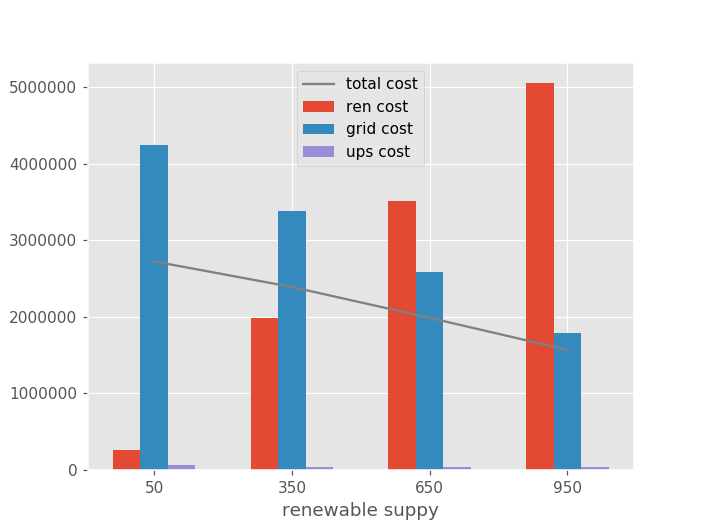

In [19]:
plt.close()
barWidth = 0.2
xlabel = ['50', '350', '650', '950']
index = np.arange(4)
plt.plot(fixRenAccuResult, 'gray', label='total cost')
plt.bar(index - barWidth, renSupplyExpAccuResult, barWidth, label='ren cost')
plt.bar(index, gridSupplyExpAccuResult, barWidth, label='grid cost')
plt.bar(index + barWidth, upsSupplyExpAccuResult, barWidth, label='ups cost')
# plt.plot(energySupply, label = 'energySupply')
# plt.bar(index - barWidth, upsSupplyExpAccuResult, barWidth, label = 'upsSupply')
# plt.bar(index, renSupplyExpAccuResult, barWidth, label = 'renSupply')
# plt.bar(index + barWidth, gridSupplyExpAccuResult, barWidth, label = 'gridSupply')
plt.xticks(index, xlabel)
plt.xlabel('renewable suppy')
plt.ylabel('dollar')
plt.legend(loc='best')
plt.title(' ')
plt.show()

In [ ]:
# plt.savefig('supplyCompare.eps')
plt.close()

In [ ]:
# How to plot 3 graphs together
# for i, col, in enumerate(features.columns):
#     plt.subplot(1, 3, i+1)
#     x = data[col]
#     y = prices
#     plt.plot(x,y,'o')
#     plt.plot(np.unique(x), npplot1d(np.plotfit(x,y,1))(np.unique(x)))
#     plt.title(col)
#     plt.xlabel(col)
#     plt.ylable('prices')